# Tree + Forecasted Trajectory Nearest Neighbor

In [44]:
import pandas as pd
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import random
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.gaussian_process import GaussianProcessRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster
import mlflow

from tqdm import tqdm
import json
from typing import List, Dict, Union, Tuple

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Object

In [2]:
class ForecastedTrajectoryNeighbors:
    def __init__(self):
        self.model = None
        self.knn = None

    def fit(self, endog, exog=None):
        self.model.fit(endog, exog)
        self.knn.fit(endog)

    def predict(self, alpha=0.5):
        y_naught = self.model.predict(y)
        y_hat = self.knn.predict(y_hat)
        ans = alpha * y_hat + (1 - alpha) * y_naught
        return ans

In [3]:
# essentially https://goldinlocks.github.io/Time-Series-Cross-Validation/
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits: int = 5, val_size: float = 0.2):
        self.n_splits = n_splits
        self.val_size = val_size

    def split(self, X, y=None):
        block_size = len(X) // self.n_splits
        indices = np.arange(len(X))
        for i in range(self.n_splits):
            start = i * block_size
            stop = start + block_size
            split = stop - int(self.val_size * (stop-start))
            yield indices[start:split], indices[split:stop]

### Helper Functions

In [4]:
def plot_forecasts(df: pd.DataFrame, pred: pd.Series, s: int):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df.date,
        y=df.consumption,
        mode='lines',
        name='Actual'
    ))
    
    fig.add_trace(go.Scatter(
        x=df.loc[s:, 'date'],
        y=pred,
        mode='lines',
        name='Forecasted'
    ))
    
    fig.update_layout(
        title="Actual vs Forecasted Values for Consumption",
        xaxis_title="Date",
        yaxis_title="Consumption (MWh)",
        legend_title="Legend"
    )
    fig.show()

## Prepare the Data

In [5]:
data = pd.read_csv("../../../data/dataset.csv", parse_dates=['date'])
thresh = int(0.9 * len(data))
data = data.dropna(axis=1, thresh=thresh).bfill().ffill().drop('demand', axis=1)
data

,date,net_generation,total_interchange,net_generation_coal,net_generation_natural_gas,net_generation_nuclear,net_generation_hydropower_and_pumped_storage,net_generation_solar,net_generation_wind,net_generation_other_fuel_sources,...,SNOW,SNWD,SX52,SX53,TMAX,TMIN,TOBS,WSFG,WT01,consumption
0,2016-01-01,67425.0,-3254.0,39962.0,20101.0,11610.0,746.0,0.0,3865.0,1122.0,...,5.0,96.0,17.0,17.0,-27.0,-77.0,-56.0,192.0,1.0,127103.0
1,2016-01-02,67906.0,-2904.0,39962.0,20101.0,11610.0,746.0,0.0,3865.0,1122.0,...,1.0,92.0,12.0,17.0,-17.0,-78.0,-53.0,192.0,1.0,127530.0
2,2016-01-03,67305.0,-3588.0,39962.0,20101.0,11610.0,746.0,0.0,3865.0,1122.0,...,3.0,85.0,12.0,17.0,3.0,-69.0,-35.0,192.0,1.0,127693.0
3,2016-01-04,77001.0,-2642.0,39962.0,20101.0,11610.0,746.0,0.0,3865.0,1122.0,...,17.0,92.0,12.0,17.0,-21.0,-84.0,-75.0,192.0,1.0,143012.0
4,2016-01-05,81083.0,-896.0,39962.0,20101.0,11610.0,746.0,0.0,3865.0,1122.0,...,1.0,90.0,8.0,17.0,-30.0,-126.0,-86.0,192.0,1.0,147147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2024-09-14,72728.0,-4453.0,21114.0,31613.0,11557.0,1049.0,1925.0,5164.0,306.0,...,0.0,0.0,217.0,217.0,282.0,136.0,169.0,156.0,1.0,145072.0
3180,2024-09-15,72659.0,-5173.0,21023.0,29004.0,11520.0,1053.0,1917.0,7857.0,283.0,...,0.0,0.0,217.0,217.0,284.0,144.0,176.0,156.0,1.0,145998.0
3181,2024-09-16,78197.0,-4749.0,22613.0,31772.0,11471.0,1118.0,2015.0,8937.0,272.0,...,0.0,0.0,217.0,217.0,295.0,141.0,163.0,156.0,1.0,155157.0
3182,2024-09-17,79791.0,-2634.0,22567.0,30658.0,11452.0,995.0,2400.0,11449.0,272.0,...,0.0,0.0,217.0,217.0,294.0,130.0,155.0,156.0,1.0,154206.0


## Splits

In [129]:
split = int(len(data) * 0.85)
train, test = data.iloc[:split, :], data.iloc[split:, :] # DO NOT TOUCH THE TEST DATA
endog_train, exog_train = train['consumption'], train.drop(['date', 'consumption'], axis=1)
endog_test, exog_test = test['consumption'], test.drop(['date', 'consumption'], axis=1)

## Baseline

In [130]:
regressor = XGBRegressor(
    random_state=RANDOM_STATE
)
forecaster = ForecasterAutoreg(
    regressor = regressor,
    lags = 1,
    differentiation = 1
)
forecaster.fit(y=endog_train)
no_exog_metric, no_exog_predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['consumption'],
    # exog               = data.drop(['consumption', 'date'], axis=1), 
    steps              = 30, # needs to mimic production
    metric             = 'mean_absolute_error',
    initial_train_size = split,
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False, # Change to False to see less information
    show_progress      = True
)
no_exog_metric

  0%|          | 0/16 [00:00<?, ?it/s]

,mean_absolute_error
0,12978.32504


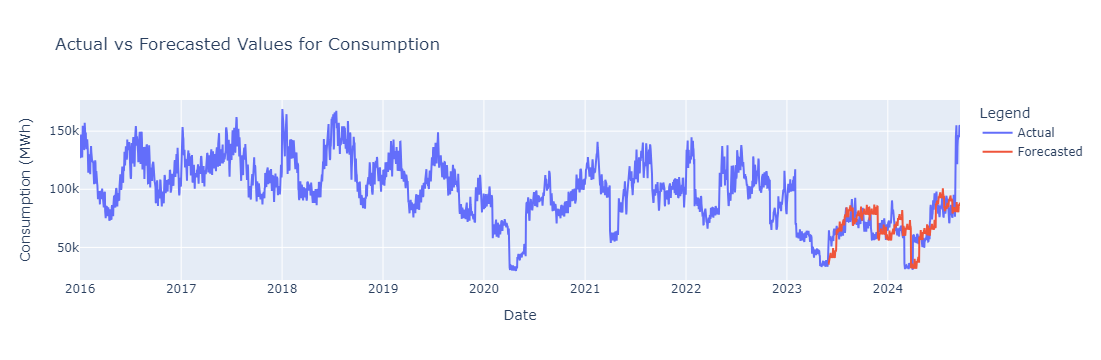

In [131]:
plot_forecasts(data, no_exog_predictions.pred, split)

In [9]:
regressor = XGBRegressor(
    random_state=RANDOM_STATE
)
forecaster = ForecasterAutoreg(
    regressor = regressor,
    lags = 1,
    differentiation = None
)
forecaster.fit(y=endog_train, exog=exog_train)
exog_metric, exog_predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['consumption'],
    exog               = data.drop(['consumption', 'date'], axis=1), 
    steps              = 30, # needs to mimic production
    metric             = 'mean_absolute_error',
    initial_train_size = split,
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False, # Change to False to see less information
    show_progress      = True,
)
exog_metric

  0%|          | 0/16 [00:00<?, ?it/s]

,mean_absolute_error
0,19859.588871


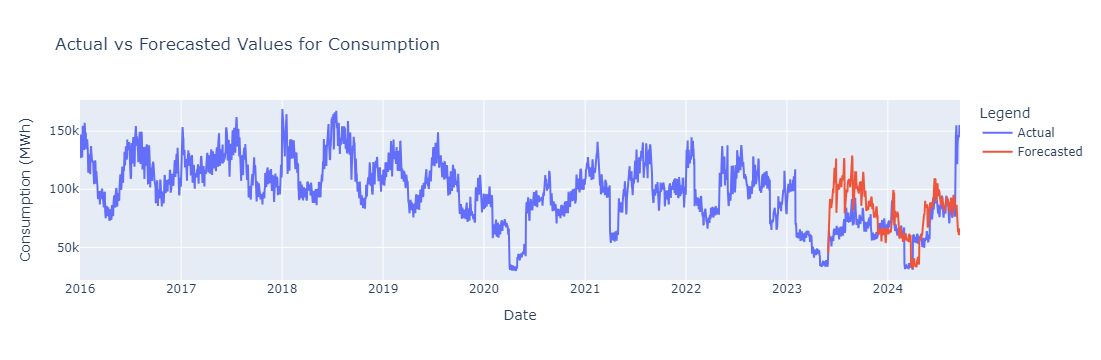

In [10]:
plot_forecasts(data, exog_predictions.pred, split)

In [11]:
importance = forecaster.get_feature_importances()
go.Figure(go.Bar(x=importance.feature, y=importance.importance))

## Bayesian Optimization

Making this for blocking time series CV

In [375]:
class BayesianOptimizationConfig:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

  def __getattr__(self, name):
    return None

In [376]:
# source 1 https://machinelearningmastery.com/what-is-bayesian-optimization/
# source 2 https://pyro.ai/examples/bo.html
# source 3 https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f
class BayesianOptimization:
    def __init__(self, config: BayesianOptimizationConfig):
        self.hp_bounds: Dict[Tuple]    = config.hp_bounds
        self.lags: List[int]           = config.lags
        self.cross_validator           = config.cross_validator
        self.data: pd.DataFrame        = config.data
        self.search_size: int          = config.search_size
        self.objective                 = config.objective
        self.num_hp: int               = len(self.hp_bounds)
        # below will contain the searched parameters
        self.searched_params: Dict     = dict()
        self.gprs: Dict              = dict()

    # ------------------------------------
    #     Bayesian Opt. Workflow Start
    # ------------------------------------
    
    def _objective_function(self, forecaster, exog=True): # returns cross validated score
        maes = []
        for x, y in self.cross_validator.split(self.data):
            endog_train = self.data.loc[x, 'consumption'].reset_index(drop=True)
            endog_val = self.data.loc[y, 'consumption'].reset_index(drop=True)
            exog_train = self.data.loc[x] \
                            .drop(['date', 'consumption'], axis=1) \
                            .reset_index(drop=True) \
                            .astype(float) if exog else None
            exog_val = self.data.loc[y] \
                            .drop(['date', 'consumption'], axis=1) \
                            .set_index(
                                pd.RangeIndex(
                                    start=len(exog_train), 
                                    stop=len(exog_train)+len(y)
                                )
                            ) \
                            .astype(float) if exog else None
            forecaster.fit(y=endog_train, exog=exog_train)
            preds = forecaster.predict(steps=len(endog_val), exog=exog_val)
            maes.append(self.objective(preds, endog_val))
        return np.mean(maes)

    def _surrogate_model(self, params: np.array, targets: np.array): # returns GPR model
        gpr = GaussianProcessRegressor(alpha=1e-3)
        gpr.fit(params, targets)
        return gpr

    def _acquisition_function(
        self, 
        gpr: GaussianProcessRegressor, 
        params: np.array, 
        kappa=2.753
    ): # returns next params using LCB?
        mu, std = gpr.predict(params, return_std=True)
        return mu - kappa * std

    # ------------------------------------
    #     Bayesian Opt. Workflow End
    # ------------------------------------

    # -----------------------
    #  Using the Object Start
    # -----------------------
    
    def _params_to_dict(self, param_array: np.array):
        return {key: value.astype(type) for (key, (_, _, type)), value in zip(bounds.items(), param_array)}
    
    def _uniform_random_params(self, size: int):
        array = np.array([
            np.random.uniform(low=low, high=high, size=size).round(3) \
            if dtype == float else np.random.randint(low=low, high=high, size=size) \
            for key, (low, high, dtype) in self.hp_bounds.items()
        ]).squeeze()
        return array
        
    def fit(self, n_iters: int):
        for lag in self.lags:
            searched_params, param_objs = None, None
            param_array = self._uniform_random_params(1)
            params = self._params_to_dict(param_array)
            for _ in range(n_iters):
                forecaster = ForecasterAutoreg(
                    regressor = XGBRegressor(**params, random_state=RANDOM_STATE),
                    lags      = lag
                )
                actual = self._objective_function(forecaster, exog=True)
                searched_params = np.vstack([searched_params, param_array]) if searched_params is not None else np.array([param_array])
                param_objs = np.vstack([param_objs, actual]) if param_objs is not None else np.array([actual])
                gpr = self._surrogate_model(searched_params, param_objs)

                random_space = self._uniform_random_params(self.search_size)
                proposed_objs = self._acquisition_function(gpr, random_space.T)
                idx = np.argmin(proposed_objs)
                param_array = random_space.T[idx]
                params = self._params_to_dict(param_array)
                
            self.searched_params[lag] = (searched_params, param_objs)
            self.gprs[lag] = gpr

    def best_params(self):
        best = np.inf
        best_params = None
        best_lag = None
        for lag, (param_array, objs) in self.searched_params.items():
            if np.min(objs) < best:
                idx = np.argmin(objs)
                params = param_array[idx]
                best_params = self._params_to_dict(params)
                best_lag = lag
                best = np.min(objs)
        return (best_params, best_lag, best)

    def best_model(self):
        params, lag, _ = self.best_params()
        forecaster = ForecasterAutoreg(
            regressor = XGBRegressor(**params, random_state=RANDOM_STATE),
            lags      = lag
        )
        return forecaster

    def gpr_(self, lag: int):
        return self.gprs[lag]

    def training_schedule(self, lag: int):
        return self.searched_params[lag]
    # -----------------------
    #  Using the Object End
    # -----------------------

In [377]:
bounds = {
    'n_estimators'    : (400, 1200, int),
    'max_depth'       : (3, 10, int),
    # 'learning_rate'   : (0.01, 1, float),
    # 'subsample'       : (0.1, 1, float),
    # 'colsample_bytree': (0.1, 1, float),
    # 'gamma'           : (0.01, 1, float),
    # 'reg_alpha'       : (0.01, 1, float),
    # 'reg_lambda'      : (0.01, 1, float)
}
config = BayesianOptimizationConfig(
    hp_bounds = bounds,
    lags = [1],
    cross_validator = BlockingTimeSeriesSplit(n_splits=4),
    data = train,
    search_size = 100,
    objective = mean_absolute_error
)
optimizer = BayesianOptimization(config)

In [378]:
optimizer.fit(30)

In [423]:
gpmodel = optimizer.gpr_(1)
X, y = optimizer.training_schedule(1)
indices = np.argsort(X[:, 0])
X_plot = X[indices, 0]
y_plot = y[indices].squeeze()
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=X_plot,
        y=y_plot
    )
)

X_new = optimizer._uniform_random_params(25).T
mu, std = gpmodel.predict(X_new, return_std=True)
indices = np.argsort(X_new[:, 0])
X_new_plot = X_new[indices, 0]
mu = mu[indices]
std = std[indices]

# fig.add_trace(
#     go.Scatter(
#         x=X_new_plot,
#         y=mu - 2*std
#     )
# )

# fig.add_trace(
#     go.Scatter(
#         x=X_new_plot,
#         y=mu + 2*std
#     )
# )
gpmodel.predict(X_new, return_std=True)

(array([8.52401526e-040, 7.47725618e-028, 1.68891359e-010, 5.50492159e-075,
        1.10580974e-101, 7.62167865e+003, 2.25596862e-092, 4.68292121e-002,
        8.38240086e-002, 4.29906438e-046, 5.42998186e-075, 2.35636246e+002,
        1.19908251e-027, 2.41936847e-003, 4.41118410e-028, 3.05374002e-007,
        1.36427598e+004, 0.00000000e+000, 6.09421522e-034, 4.96643825e-093,
        6.15406288e-016, 1.98065985e-017, 2.75043905e+000, 4.74376442e-007,
        8.61202427e-060]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.92994619, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99993835, 1.        , 1.        , 1.        ,
        1.        , 0.79529119, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99999999, 1.        , 1.        ]))

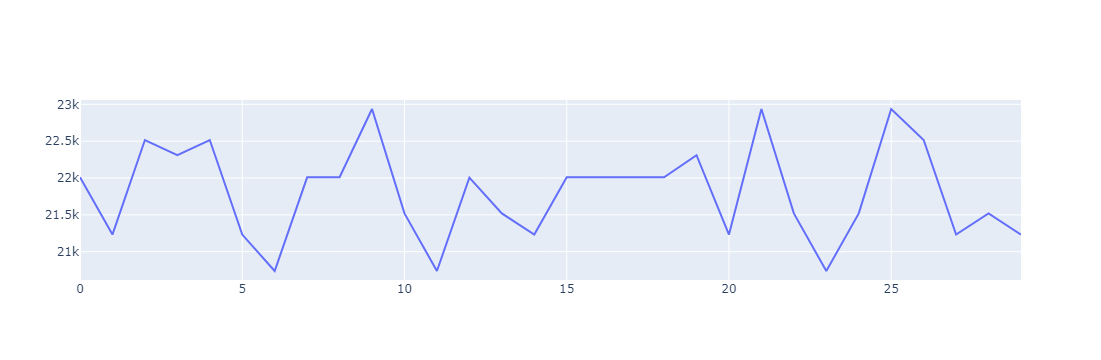

In [380]:
objs = optimizer.training_schedule(1)[1]
go.Figure(
    go.Scatter(
        y=objs.squeeze(),
        mode='lines'
    )
)

## Hyper-Parameter Tuning and CV

In [23]:
params = {
    'n_estimators': 100
}
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(**params, random_state=RANDOM_STATE),
    lags      = 72
)

In [ ]:
# Lags grid
lags_grid = []

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

In [ ]:
results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data['consumption'],
    exog               = data.drop(['consumption', 'date'], axis=1),
    search_space       = search_space,
    steps              = 30,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = int(split * 0.8),
    fixed_train_size   = True,
    n_trials           = 25,
    random_state       = RANDOM_STATE,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

In [ ]:
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

In [14]:
??ForecasterAutoreg

Init signature:
ForecasterAutoreg(
    regressor: object,
    lags: Union[int, numpy.ndarray, list],
    transformer_y: Optional[object] = None,
    transformer_exog: Optional[object] = None,
    weight_func: Optional[Callable] = None,
    differentiation: Optional[int] = None,
    fit_kwargs: Optional[dict] = None,
    binner_kwargs: Optional[dict] = None,
    forecaster_id: Union[str, int, NoneType] = None,
) -> None
Source:        
class ForecasterAutoreg(ForecasterBase):
    """
    This class turns any regressor compatible with the scikit-learn API into a
    recursive autoregressive (multi-step) forecaster.
    
    Parameters
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API
    lags : int, list, numpy ndarray, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1. 
    
        - `int`: include lags from 1 to `lags` (included).

## Evaluation